In [10]:
!pip install opencv-python
!pip install imbalanced-learn

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms, models
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import datetime
import kagglehub


In [12]:

# Download latest version of the dataset
path = kagglehub.dataset_download("msambare/fer2013")
print("Dataset downloaded to (cache):", path)

# The dataset is now available at 'path' within the Colab environment.
# You can access the data from this location.

Using Colab cache for faster access to the 'fer2013' dataset.
Dataset downloaded to (cache): /kaggle/input/fer2013


In [13]:
# Create output directory for saving all files
output_dir = '/content/drive/MyDrive/Colab Notebooks'
os.makedirs(output_dir, exist_ok=True)
print(f"All outputs will be saved to: {output_dir}")

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define dataset paths
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

# Define emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

All outputs will be saved to: /content/drive/MyDrive/Colab Notebooks
Using device: cpu


In [14]:
# Custom Dataset Class
class FERDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.classes = emotion_classes
        self.image_paths = []
        self.labels = []

        # Read images from class folders
        for i, class_name in enumerate(self.classes):
            class_path = os.path.join(data_path, class_name)
            for img_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, img_name))
                self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [15]:
# Define data transformations with more augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
}

Training Set Class Distribution:
angry: 3995
disgust: 436
fear: 4097
happy: 7215
neutral: 4965
sad: 4830
surprise: 3171


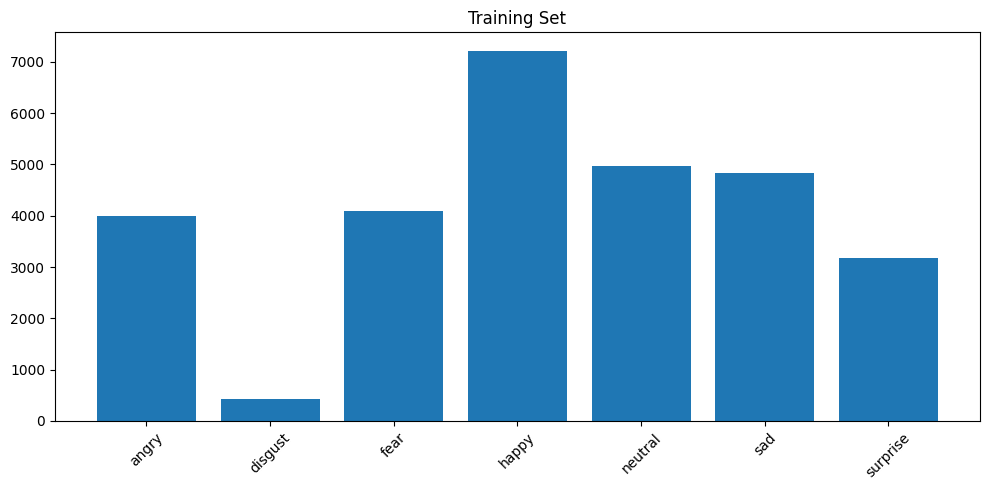

Test Set Class Distribution:
angry: 958
disgust: 111
fear: 1024
happy: 1774
neutral: 1233
sad: 1247
surprise: 831


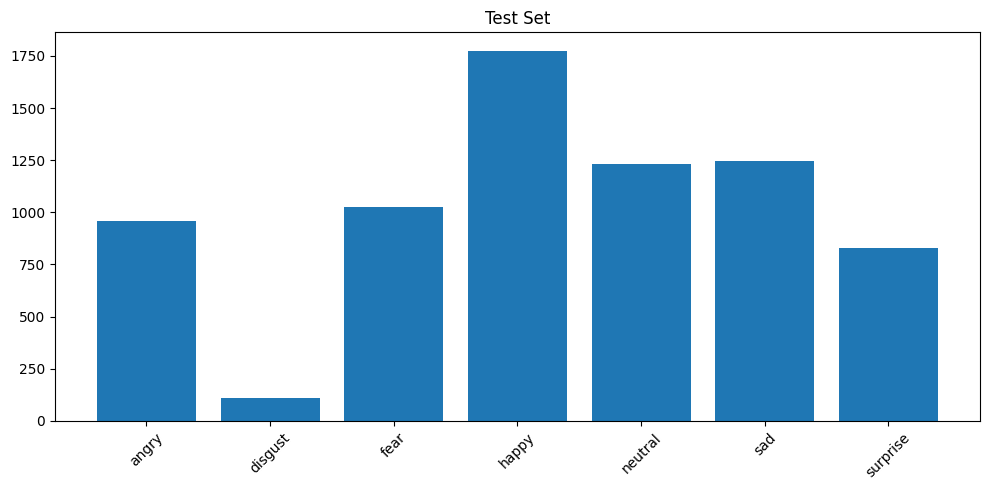

In [16]:
# Create datasets
train_dataset = FERDataset(train_dir, transform=data_transforms['train'])
test_dataset = FERDataset(test_dir, transform=data_transforms['test'])

# Analyze class distribution
def analyze_class_distribution(dataset, title):
    class_counts = Counter(dataset.labels)
    print(f"{title} Class Distribution:")
    for i, cls in enumerate(emotion_classes):
        print(f"{cls}: {class_counts[i]}")

    plt.figure(figsize=(10, 5))
    plt.bar(emotion_classes, [class_counts[i] for i in range(len(emotion_classes))])
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the plot
    plot_path = os.path.join(output_dir, f"{title.lower().replace(' ', '_')}_distribution.png")
    plt.savefig(plot_path)
    plt.show()
    plt.close()

    return class_counts, plot_path

train_class_counts, train_dist_plot_path = analyze_class_distribution(train_dataset, "Training Set")
test_class_counts, test_dist_plot_path = analyze_class_distribution(test_dataset, "Test Set")


In [17]:
# Calculate class weights for imbalance handling
class_weights = []
total_samples = sum(train_class_counts.values())
for i in range(len(emotion_classes)):
    weight = total_samples / (len(emotion_classes) * train_class_counts[i]) if train_class_counts[i] > 0 else 1.0
    class_weights.append(weight)

# Normalize weights
class_weights = torch.FloatTensor(class_weights).to(device)
print("Class weights:", class_weights.cpu().numpy())

# Create weighted sampler to handle class imbalance
sample_weights = [0] * len(train_dataset)
for idx, (_, label) in enumerate(train_dataset):
    sample_weights[idx] = class_weights[label].item()

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Create dataloaders with weighted sampler
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Class weights: [1.0266047  9.406619   1.0010461  0.56843877 0.82603943 0.8491275
 1.293373  ]


In [18]:
# Define the CNN model
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Calculate the size of the flattened features
        self._to_linear = None
        self._get_conv_output((1, 1, 48, 48))

        # Enhanced fully connected layers with more neurons
        self.fc1 = nn.Linear(self._to_linear, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, num_classes)

    def _get_conv_output(self, shape):
        input = torch.rand(shape)
        output = self._forward_conv(input)
        self._to_linear = int(np.prod(output.shape))

    def _forward_conv(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))  # Additional conv layer
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

In [19]:
# Initialize model, loss function with class weights, and optimizer
print("Initializing enhanced model...")
model = EmotionCNN().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Use a slightly lower learning rate
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=7)  # Increased patience

# Enhanced early stopping with more patience
class EarlyStopping:
    def __init__(self, patience=10, delta=0.001, path='best_emotion_model.pth'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = os.path.join(output_dir, path)
        self.best_accuracy = 0.0

    def __call__(self, val_loss, val_accuracy, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_accuracy = val_accuracy
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_accuracy = val_accuracy
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Enhanced training function with more epochs
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=100, patience=15):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, path='best_emotion_model.pth')

    print("Starting training...")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Print progress every 50 batches
            if batch_idx % 50 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation phase
        model.eval()
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_epoch_loss = test_running_loss / len(test_loader.dataset)
        test_epoch_acc = 100 * test_correct / test_total
        test_losses.append(test_epoch_loss)
        test_accuracies.append(test_epoch_acc)

        # Update learning rate based on validation accuracy
        scheduler.step(test_epoch_acc)

        # Early stopping check
        early_stopping(test_epoch_loss, test_epoch_acc, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            print(f"Best validation accuracy: {early_stopping.best_accuracy:.2f}%")
            break

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
              f'Test Loss: {test_epoch_loss:.4f}, Test Acc: {test_epoch_acc:.2f}%')

        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint_path = os.path.join(output_dir, f'checkpoint_epoch_{epoch+1}.pth')
            torch.save(model.state_dict(), checkpoint_path)

    # Load the best model
    print("Loading best model...")
    model.load_state_dict(torch.load(os.path.join(output_dir, 'best_emotion_model.pth')))

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.legend()
    plt.title('Loss over epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')

    # Save the training history plot
    training_plot_path = os.path.join(output_dir, 'training_history.png')
    plt.savefig(training_plot_path)
    plt.show()
    plt.close()

    return model, train_losses, test_losses, train_accuracies, test_accuracies, training_plot_path


Initializing enhanced model...
Model parameters: 7,719,303


Starting training...
Epoch 1/100, Batch 0/449, Loss: 1.9593
Epoch 1/100, Batch 50/449, Loss: 1.1716
Epoch 1/100, Batch 100/449, Loss: 1.3552
Epoch 1/100, Batch 150/449, Loss: 1.4034
Epoch 1/100, Batch 200/449, Loss: 1.4244
Epoch 1/100, Batch 250/449, Loss: 1.4726
Epoch 1/100, Batch 300/449, Loss: 1.0120
Epoch 1/100, Batch 350/449, Loss: 1.2224
Epoch 1/100, Batch 400/449, Loss: 1.0119
Epoch 1/100, Train Loss: 1.2713, Train Acc: 17.11%, Test Loss: 2.1565, Test Acc: 11.01%
Epoch 2/100, Batch 0/449, Loss: 0.8716
Epoch 2/100, Batch 50/449, Loss: 1.4360
Epoch 2/100, Batch 100/449, Loss: 1.0910
Epoch 2/100, Batch 150/449, Loss: 1.7479
Epoch 2/100, Batch 200/449, Loss: 0.8324
Epoch 2/100, Batch 250/449, Loss: 0.9588
Epoch 2/100, Batch 300/449, Loss: 0.8765
Epoch 2/100, Batch 350/449, Loss: 0.9360
Epoch 2/100, Batch 400/449, Loss: 0.8036
EarlyStopping counter: 1 out of 15
Epoch 2/100, Train Loss: 1.0502, Train Acc: 25.38%, Test Loss: 2.2378, Test Acc: 15.16%
Epoch 3/100, Batch 0/449, Loss: 0.87

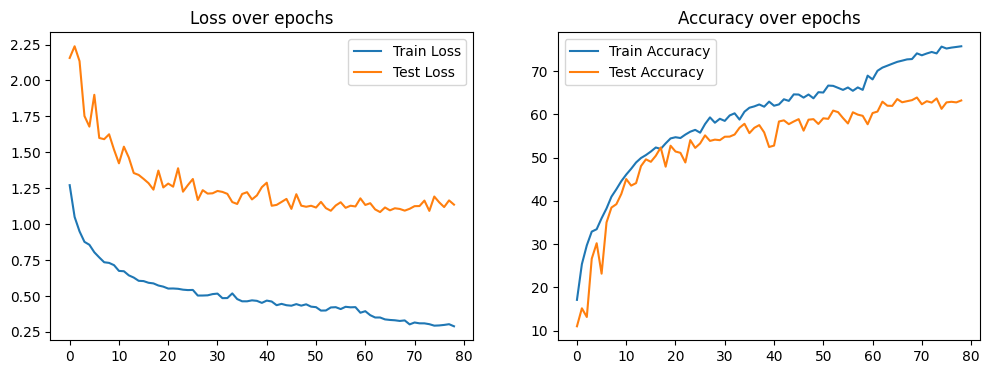

Saving final model...


In [18]:

# Train the model with more epochs
trained_model, train_losses, test_losses, train_accuracies, test_accuracies, training_plot_path = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler,
    num_epochs=100, patience=15
)

# Save the final model
print("Saving final model...")
final_model_path = os.path.join(output_dir, 'emotion_model.pth')
torch.save(trained_model.state_dict(), final_model_path)




In [22]:
print(f"Model saved as: {final_model_path}")

Model saved as: /content/drive/MyDrive/Colab Notebooks/emotion_model.pth


In [19]:
# Define Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=emotion_classes, output_dict=True)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=emotion_classes))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_classes, yticklabels=emotion_classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Save the confusion matrix plot
    cm_plot_path = os.path.join(output_dir, 'confusion_matrix.png')
    plt.savefig(cm_plot_path)
    plt.show()
    plt.close()

    # Calculate overall accuracy
    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"Overall Accuracy: {accuracy:.2f}%")

    return accuracy, report, cm, cm_plot_path

Evaluating model...
Classification Report:
              precision    recall  f1-score   support

       angry       0.50      0.59      0.54       958
     disgust       0.60      0.71      0.65       111
        fear       0.48      0.41      0.44      1024
       happy       0.88      0.76      0.82      1774
     neutral       0.57      0.62      0.59      1233
         sad       0.52      0.45      0.48      1247
    surprise       0.65      0.85      0.74       831

    accuracy                           0.62      7178
   macro avg       0.60      0.63      0.61      7178
weighted avg       0.63      0.62      0.62      7178



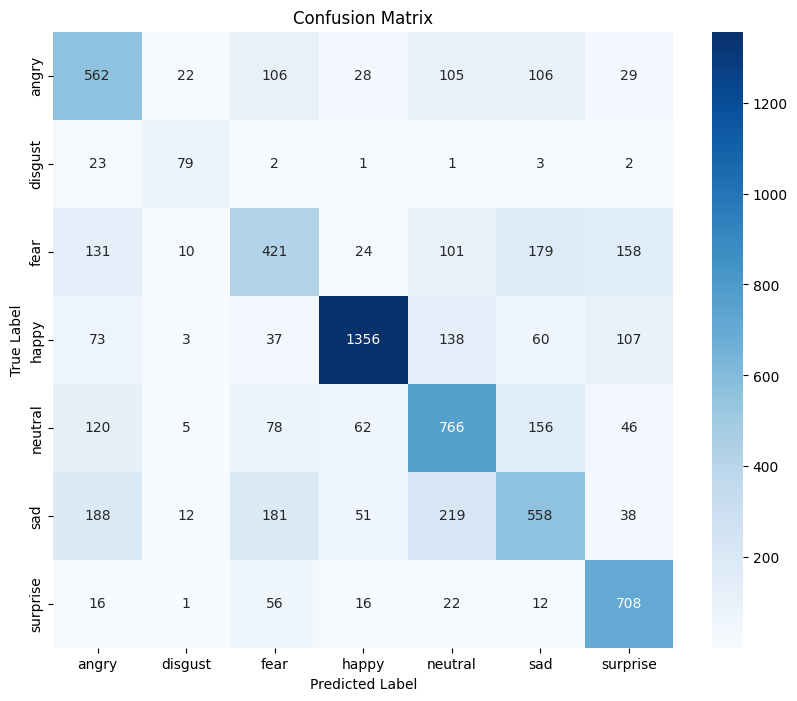

Overall Accuracy: 61.99%


In [20]:

# Evaluate the model
print("Evaluating model...")
final_accuracy, classification_report_dict, confusion_matrix_data, cm_plot_path = evaluate_model(trained_model, test_loader)

In [21]:
# Test with sample images
def predict_emotion(model, image_path, transform):
    model.eval()
    image = Image.open(image_path).convert('L')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        probabilities = F.softmax(outputs, dim=1)[0] * 100

    return emotion_classes[predicted.item()], probabilities.cpu().numpy()

# Test with sample images
print("Testing with sample images...")
for emotion in emotion_classes:
    sample_image_path = f"{test_dir}/{emotion}/"
    if os.path.exists(sample_image_path):
        image_files = os.listdir(sample_image_path)
        if image_files:
            test_image = os.path.join(sample_image_path, image_files[0])
            emotion_pred, probs = predict_emotion(trained_model, test_image, data_transforms['test'])
            print(f"True Emotion: {emotion}, Predicted Emotion: {emotion_pred}")
            for i, cls in enumerate(emotion_classes):
                print(f"{cls}: {probs[i]:.2f}%")
            print()
            break


# Test with a sample image (replace with your image path)
sample_image_path = "/kaggle/input/fer2013/test/neutral/PrivateTest_11239107.jpg"  # Replace with actual path
if os.path.exists(sample_image_path):
    emotion, probs = predict_emotion(trained_model, sample_image_path, data_transforms['test'])
    print(f"Predicted Emotion: {emotion}")
    for i, cls in enumerate(emotion_classes):
        print(f"{cls}: {probs[i]:.2f}%")
else:
    print("Sample image not found. Please provide a valid path.")

print(f"\nAll outputs have been saved to: {output_dir}")
print(f"Model saved as: {final_model_path}")

Testing with sample images...
True Emotion: angry, Predicted Emotion: angry
angry: 36.51%
disgust: 0.20%
fear: 33.49%
happy: 12.82%
neutral: 0.46%
sad: 1.42%
surprise: 15.11%

Predicted Emotion: neutral
angry: 26.69%
disgust: 0.42%
fear: 12.57%
happy: 1.54%
neutral: 38.16%
sad: 18.61%
surprise: 2.01%

All outputs have been saved to: /content/drive/MyDrive/Colab Notebooks
Model saved as: /content/drive/MyDrive/Colab Notebooks/emotion_model.pth
